# Forward PINN for Nonlinear Frictional System

This notebook demonstrates how to use Physics-Informed Neural Networks (PINNs) with measurement data to solve a nonlinear frictional system modeled by a spring-block slider. We predict the nondimensional slip ($\tilde{u}$), slip rate ($\tilde{v}$), and state variable ($\tilde{\theta}$) from a dataset, and compare our PINN predictions with the true (interpolated) measurements.

The governing system of ODEs is:

\begin{align*}
\frac{d\tilde{u}}{d\tilde{t}} &= \tilde{v}, \\
\frac{d\tilde{v}}{d\tilde{t}} &= \kappa(v_0 \tilde{t} - \tilde{u}) - \alpha\left(f_0 + a \ln \tilde{v} + b \ln \tilde{\theta}\right), \\
\frac{d\tilde{\theta}}{d\tilde{t}} &= -\tilde{v}\tilde{\theta}\ln(\tilde{v}\tilde{\theta}).
\end{align*}

The loss function is composed of a residual loss, a boundary loss, and a measurement loss. In this example, we use 25 equidistant measurement data points obtained from the dataset.

In [1]:
import deepxde as dde
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Set random seeds for reproducibility
np.random.seed(123)
tf.random.set_seed(123)

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term



## Load and Process the Dataset

We load the dataset from a CSV file and select the first 10,000 data points. Then, we interpolate these data to obtain 25 equidistant measurement points for each variable: slip ($u$), slip rate ($v$), and state variable ($\theta$). Note that the measurement loss includes data of slip ($u$) and slip rate ($v$) only. This is because state variable cannot be directly measured.

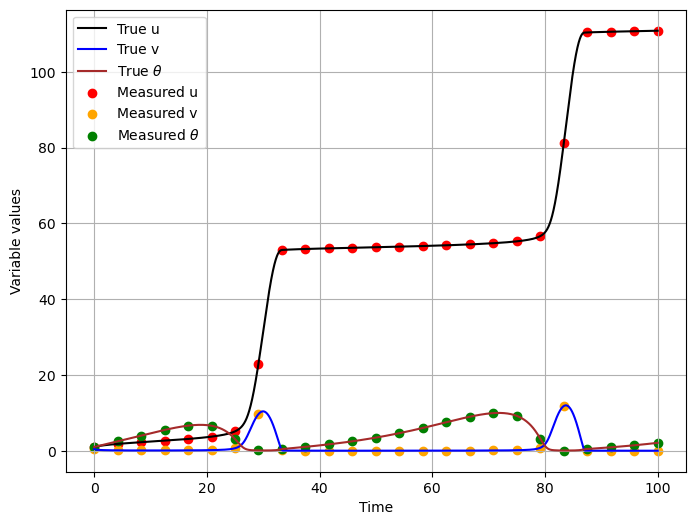

In [4]:
raw = pd.read_csv('../Dataset/sbm1.csv')
raw = raw.iloc[0:10000]  # Select the first 10,000 data points

# Extract observation time and variables from the dataset
observe_t = raw['Var1']
u_ext = raw['y1_1']
v_ext = raw['y1_2']
theta_ext = raw['y1_3']

# Interpolate to get 25 equidistant measurement points over the interval [0, 100]
t_int = np.linspace(0, 100, 25)
u_int = np.interp(t_int, observe_t.values, u_ext.values)
v_int = np.interp(t_int, observe_t.values, v_ext.values)
theta_int = np.interp(t_int, observe_t.values, theta_ext.values)

# Plot the original data and the interpolated measurements
plt.figure(figsize=(8, 6))
plt.plot(observe_t, u_ext, label="True u", color="black")
plt.plot(observe_t, v_ext, label="True v", color="blue")
plt.plot(observe_t, theta_ext, label=r"True $\theta$", color="brown")

plt.scatter(t_int, u_int, label="Measured u", color="red")
plt.scatter(t_int, v_int, label="Measured v", color="orange")
plt.scatter(t_int, theta_int, label=r"Measured $\theta$", color="green")

plt.xlabel('Time')
plt.ylabel('Variable values')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# Reshape the interpolated data to column vectors (DeepXDE expects 2D arrays)
observe_t = t_int.reshape((-1, 1))
u_ext = u_int.reshape((-1, 1))
v_ext = v_int.reshape((-1, 1))
theta_ext = v_int.reshape((-1, 1))

In [6]:
# Define observation boundary conditions using DeepXDE's PointSetBC
observe_y0 = dde.icbc.PointSetBC(observe_t, u_ext, component=0)
observe_y1 = dde.icbc.PointSetBC(observe_t, v_ext, component=1)
observe_y2 = dde.icbc.PointSetBC(observe_t, theta_ext, component=2)

## Formulation of the Problem

The nondimensionalized system of ODEs that we aim to solve is:

\begin{align*}
\frac{d\tilde{u}}{d\tilde{t}} &= \tilde{v}, \\
\frac{d\tilde{v}}{d\tilde{t}} &= \kappa(v_0 \tilde{t} - \tilde{u}) - \alpha\left(f_0 + a \ln \tilde{v} + b \ln \tilde{\theta}\right), \\
\frac{d\tilde{\theta}}{d\tilde{t}} &= -\tilde{v}\tilde{\theta}\ln(\tilde{v}\tilde{\theta}).
\end{align*}

We incorporate the measurement data as boundary conditions and train the PINN to predict $\tilde{u}$, $\tilde{v}$, and $\tilde{\theta}$.

In [7]:
# Set model parameters
alpha = 9.81  # Constant representing the normal force
kappa = 0.25  # Spring stiffness
v0 = 1        # Driving plate velocity
f0 = 0.2      # Reference friction coefficient
a = 0.2       # Frictional parameter
b = 0.3       # Frictional parameter

In [8]:
def ode_system(x, y):
    """
    Defines the modified ODE system using DeepXDE's automatic differentiation.
    
    Parameters:
      x : Tensor of the independent variable (time).
      y : Tensor with three components: [\tilde{u}, \tilde{v}, \tilde{\theta}].
    
    Returns:
      A list containing the residuals of the three ODEs.
    """
    
    # Split the output tensor into individual variables
    u = y[:, 0:1]
    v = y[:, 1:2]
    theta = y[:, 2:3]

    # Compute time derivatives using automatic differentiation
    du_t = dde.grad.jacobian(y, x, i=0)
    dv_t = dde.grad.jacobian(y, x, i=1)
    dtheta_t = dde.grad.jacobian(y, x, i=2)

    # Define the residuals for each ODE
    res_u = du_t - v
    res_v = dv_t - kappa * (v0 * x - u) + alpha * (f0 + a * tf.math.log(v) + b * tf.math.log(theta))
    res_theta = dtheta_t + (v * theta * tf.math.log(v * theta))

    return [res_u, res_v, res_theta]

## Compile and Train the PINN Model

We now define the time domain, create the PDE data object (which includes the measurement boundary conditions), and define the neural network architecture. The network has 6 hidden layers with 64 neurons each. An output transformation is applied so that the initial conditions are satisfied:

- $\tilde{u}(0) = 1$
- $\tilde{v}(0) = 0.5$
- $\tilde{\theta}(0) = 1$

Finally, we compile and train the model for 50,000 iterations.

In [9]:
# Define the time domain geometry
geom = dde.geometry.TimeDomain(0, 100)

# Create the PDE data object including the observation boundary conditions
data = dde.data.PDE(geom, ode_system, [observe_y0, observe_y1], 20000, 0, num_test=3000)

In [10]:
# Define the neural network architecture: 1 input, 6 hidden layers of 64 neurons, 3 outputs
layer_size = [1] + [64] * 6 + [3]
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)

In [11]:
def output_transform(t, y):
    """
    Transforms the raw network output so that the initial conditions are satisfied at t = 0.
    Since tf.tanh(0) = 0, at t = 0 the output equals the initial conditions.
    """
    y1 = y[:, 0:1]
    y2 = y[:, 1:2]
    y3 = y[:, 2:3]
    
    # Set initial conditions: u(0)=1, v(0)=0.5, theta(0)=1
    return tf.concat([y1 * tf.tanh(t) + 1, y2 * tf.tanh(t) + 0.5, y3 * tf.tanh(t) + 1], axis=1)

In [12]:
net.apply_output_transform(output_transform)

In [13]:
# Create and compile the model
model = dde.Model(data, net)
model.compile(
    "adam",
    lr=0.0001,
    loss_weights=[1, 1, 1, 1, 1]
    )

# Create output directory for saving checkpoints
path = "./../output/forward_data/model"
os.makedirs(path, exist_ok=True)
checkpoint_path = os.path.join(path, "model.ckpt")
checker = dde.callbacks.ModelCheckpoint(
      checkpoint_path, save_better_only=True, period=50
  )

# Train the model for 50,000 iterations (using 'epochs' which is equivalent to iterations here)
losshistory, train_state = model.train(epochs=50000, callbacks=[checker])

Compiling model...
Building feed-forward neural network...
'build' took 0.204348 s

'compile' took 1.531377 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [1.28e+00, 1.35e+02, 5.69e-01, 3.60e+03, 8.35e+00]    [1.28e+00, 1.35e+02, 5.69e-01, 3.60e+03, 8.35e+00]    []  
INFO:tensorflow:./../output/forward_data/model\model.ckpt-50.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:./../output/forward_data/model\model.ckpt-50.ckpt.data-00000-of-00001
INFO:tensorflow:100
INFO:tensorflow:./../output/forward_data/model\model.ckpt-50.ckpt.index
INFO:tensorflow:100
INFO:tensorflow:./../output/forward_data/model\model.ckpt-50.ckpt.meta
INFO:tensorflow:500


KeyboardInterrupt: 

## Prediction and Plotting

After training the PINN, we predict the solution over the entire time domain and compare the predictions with the true data.

In [ ]:
# Reassign the original observation data (for plotting)
observe_t = raw['Var1']
u_ext = raw['y1_1']
v_ext = raw['y1_2']
theta_ext = raw['y1_3']

# Plot the true data
plt.figure(figsize=(10, 6))
plt.xlabel("Time")
plt.ylabel("y")
plt.plot(observe_t, u_ext, color="black", label="True u")
plt.plot(observe_t, v_ext, color="blue", label="True v")
plt.plot(observe_t, theta_ext, color="brown", label=r"True $\theta$")

# Predict the solution using the trained model over 10,000 time points
t = np.linspace(0, 100, 10000).reshape(-1, 1)
sol_pred = model.predict(t)
u_pred = sol_pred[:, 0]
v_pred = sol_pred[:, 1]
theta_pred = sol_pred[:, 2]

# Plot the predicted solution (dashed lines)
plt.plot(t, u_pred, color="red", linestyle="dashed", label="Predicted u")
plt.plot(t, v_pred, color="orange", linestyle="dashed", label="Predicted v")
plt.plot(t, theta_pred, color="green", linestyle="dashed", label=r"Predicted $\theta$")

plt.legend()
plt.grid(True)
plt.savefig('./../output/forward_data/pred.png')
plt.show()